In [1]:
from __future__ import division, print_function
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
def random_split(spectra, test_size=0.3, random_state=None, shuffle=True, stratify=None):
    """implement random_split by using sklearn.model_selection.train_test_split function. See
    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    for more infomation.
    """
    return train_test_split(
        spectra,
        test_size=test_size,
        random_state=random_state,
        shuffle=shuffle,
        stratify=stratify)


def kennardstone(spectra, test_size=0.2, metric='euclidean', *args, **kwargs):
    """Kennard Stone Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    --------
    Kennard, R. W., & Stone, L. A. (1969). Computer aided design of experiments.
    Technometrics, 11(1), 137-148. (https://www.jstor.org/stable/1266770)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        distance = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def spxy(spectra, yvalues, test_size=0.2, metric='euclidean', *args, **kwargs):
    """SPXY Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    ---------
    Galvao et al. (2005). A method for calibration and validation subset partitioning.
    Talanta, 67(4), 736-740. (https://www.sciencedirect.com/science/article/pii/S003991400500192X)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        yvalues = yvalues.reshape(yvalues.shape[0], -1)
        distance_spectra = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        distance_y = cdist(yvalues, yvalues, metric=metric, *args, **kwargs)
        distance_spectra = distance_spectra / distance_spectra.max()
        distance_y = distance_y / distance_y.max()

        distance = distance_spectra + distance_y
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def max_min_distance_split(distance, train_size):
    """sample set split method based on maximun minimun distance, which is the core of Kennard Stone
    method
    Parameters
    ----------
    distance : distance matrix
        semi-positive real symmetric matrix of a certain distance metric
    train_size : train data sample size
        should be greater than 2
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero-based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero-based
    """

    select_pts = []
    remaining_pts = [x for x in range(distance.shape[0])]

    # first select 2 farthest points
    first_2pts = np.unravel_index(np.argmax(distance), distance.shape)
    select_pts.append(first_2pts[0])
    select_pts.append(first_2pts[1])

    # remove the first 2 points from the remaining list
    remaining_pts.remove(first_2pts[0])
    remaining_pts.remove(first_2pts[1])

    for i in range(train_size - 2):
        # find the maximum minimum distance
        select_distance = distance[select_pts, :]
        min_distance = select_distance[:, remaining_pts]
        min_distance = np.min(min_distance, axis=0)
        max_min_distance = np.max(min_distance)

        # select the first point (in case that several distances are the same, choose the first one)
        points = np.argwhere(select_distance == max_min_distance)[:, 1].tolist()
        for point in points:
            if point in select_pts:
                pass
            else:
                select_pts.append(point)
                remaining_pts.remove(point)
                break
    return select_pts, remaining_pts

In [7]:
import sys
import os
import math
import re
import json
import scipy
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import IPython.display

from sklearn.metrics import *  # we use global() to access the imported functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier # ExtraTreeClassifier only works in ensembles
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
# from scipy.integrate import quad
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import OneHotEncoder
from statsmodels.multivariate import manova
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

from pyNNRW.elm import ELMClassifier
from pyNNRW.rvfl import RVFLClassifier

from qsi.vis.plt2base64 import plt2html
from qsi.vis.plot_components import plot_components_2d
from qsi.vis.feature_importance import plot_feature_importance
from qsi.vis.unsupervised_dimension_reductions import unsupervised_dimension_reductions
from cla.vis.confusion_matrix import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import top_k_accuracy_score, classification_report

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


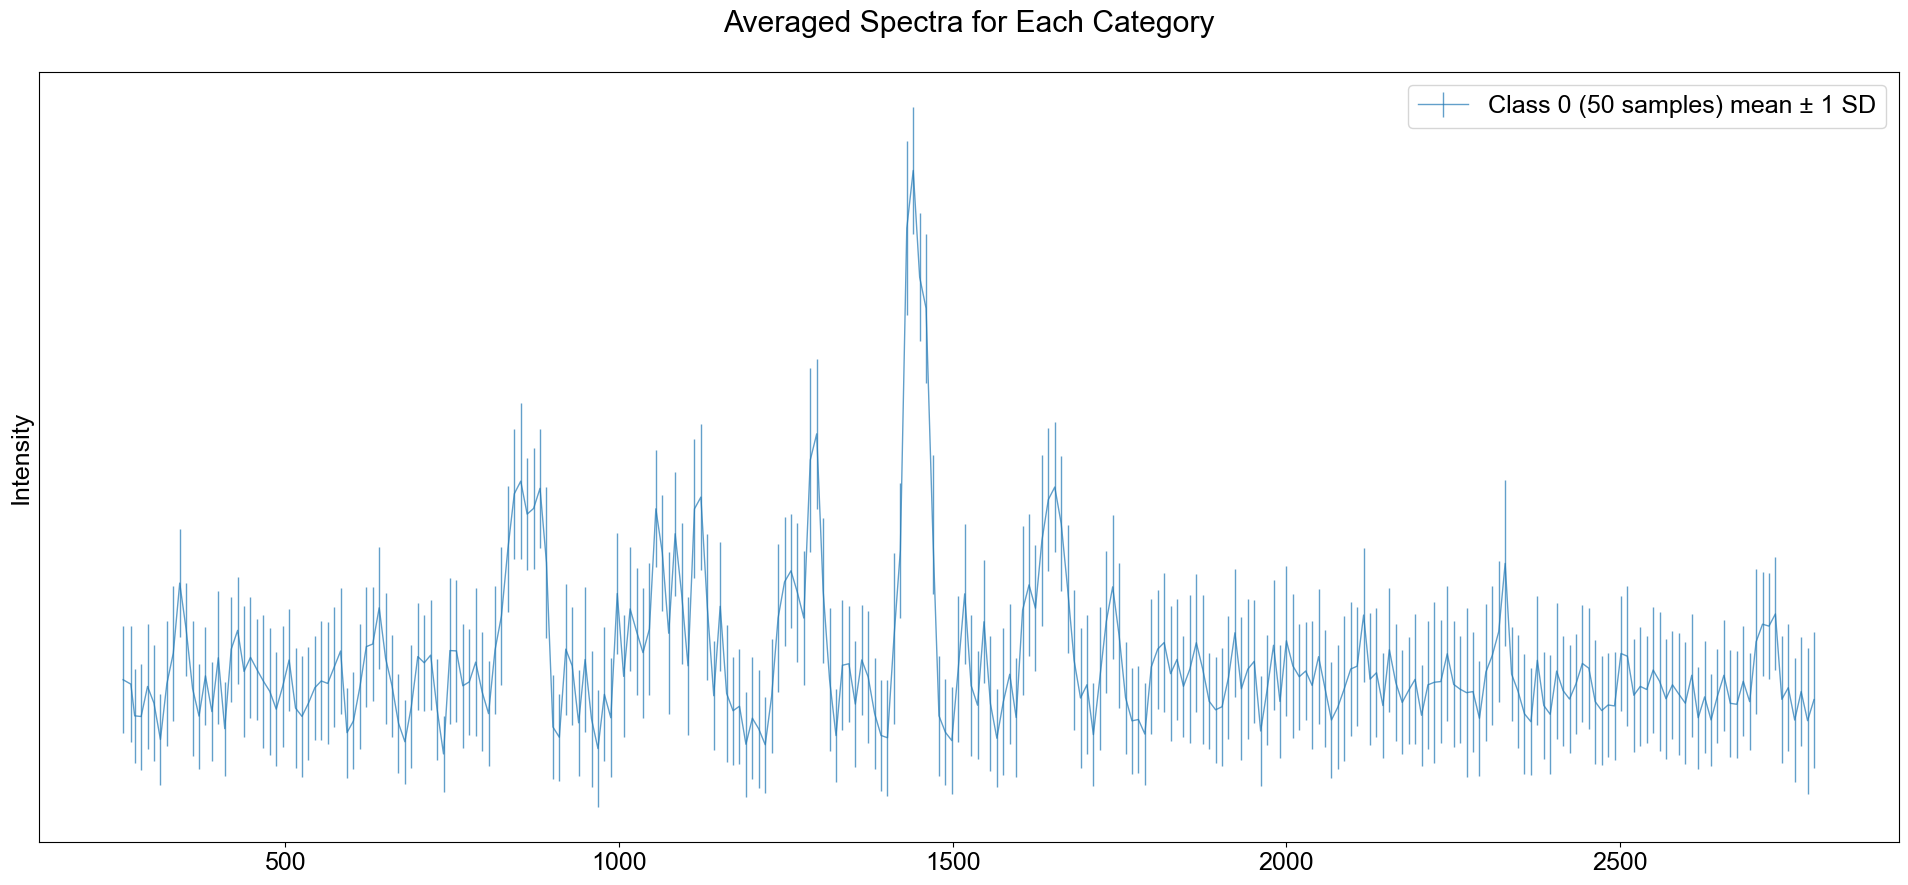

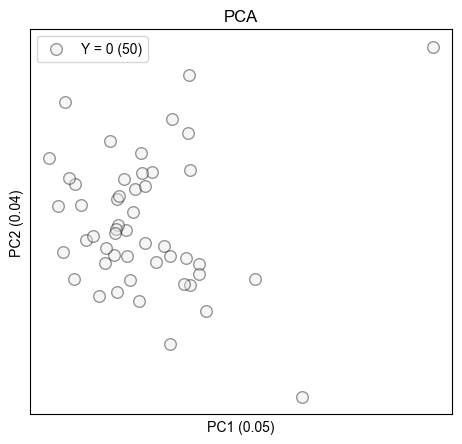

In [9]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-guangming牛merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [10]:
X.shape

(50, 264)

In [13]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [15]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [17]:
import numpy as np

# 保存训练集数据
np.savetxt('guangming牛.train_data.csv', X_train, delimiter=',')
np.savetxt('guangming牛.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('guangming牛.test_data.csv', X_test, delimiter=',')
np.savetxt('guangming牛.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


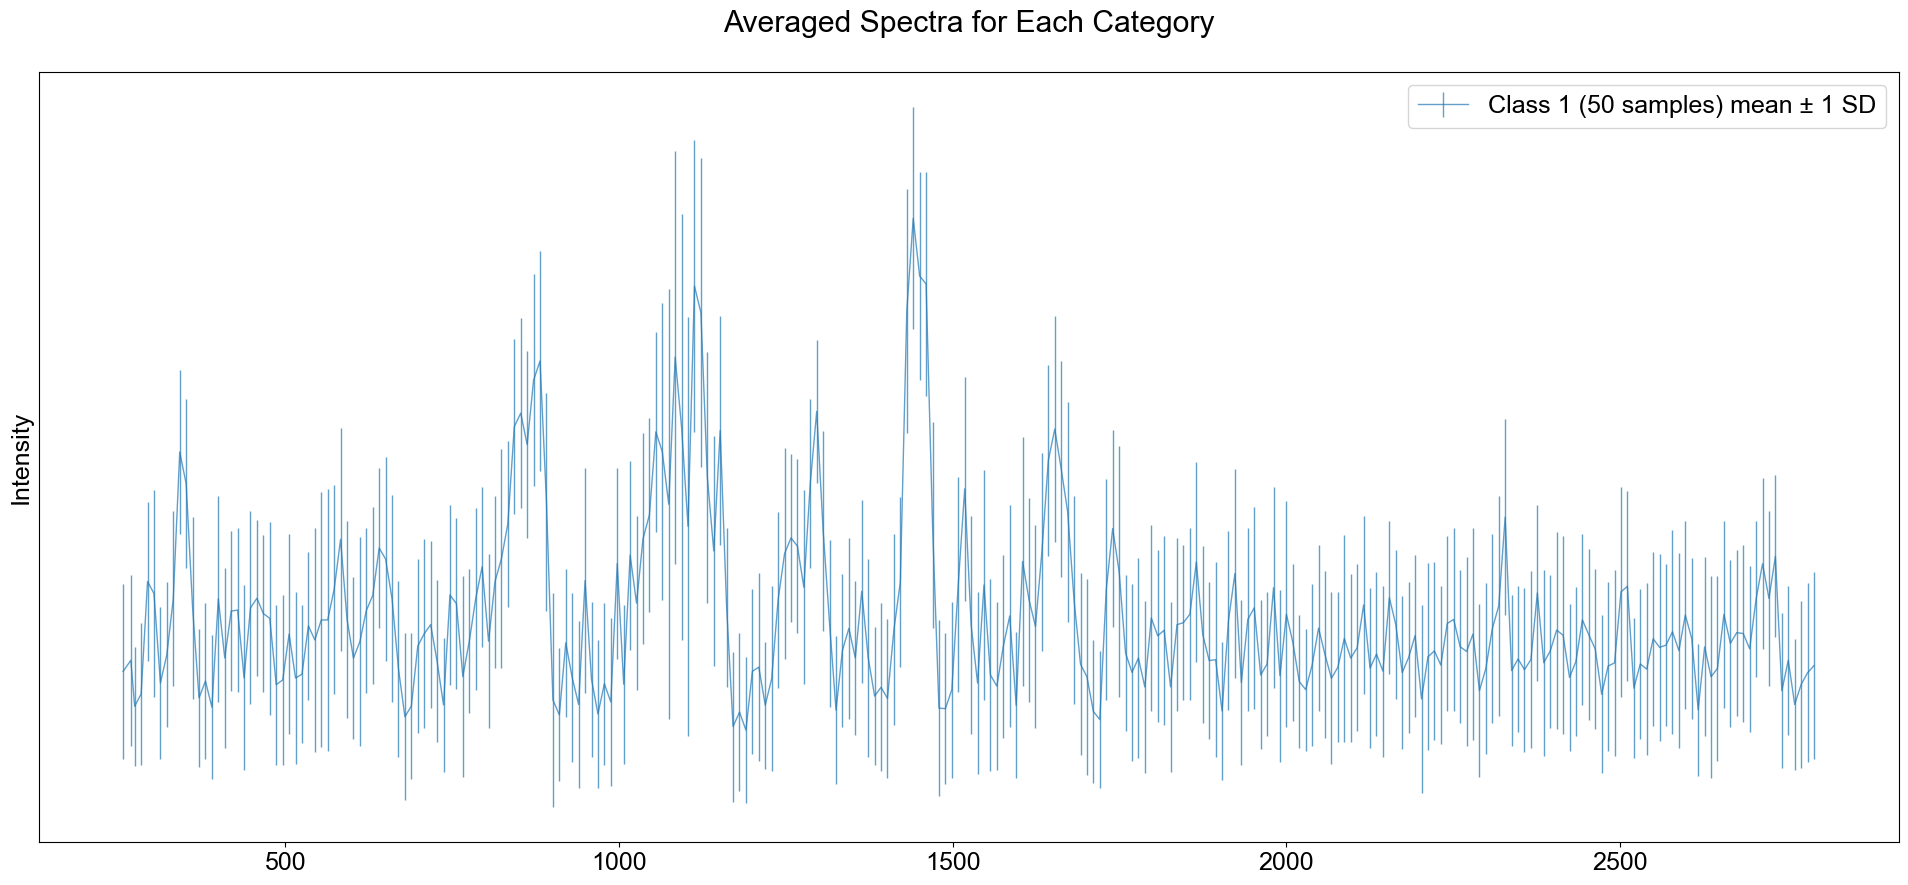

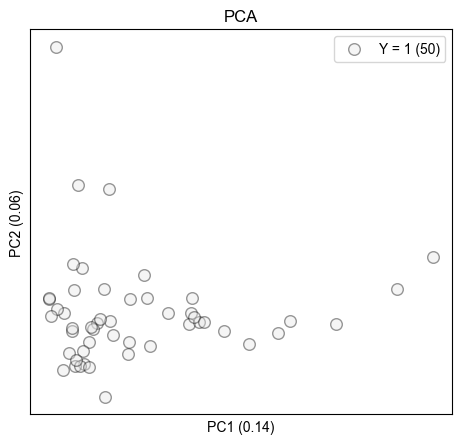

In [19]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-baifeilao水牛merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [20]:
X.shape

(50, 264)

In [21]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [22]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [27]:
import numpy as np

# 保存训练集数据
np.savetxt('baifeilao水牛.train_data.csv', X_train, delimiter=',')
np.savetxt('baifeilao水牛.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('baifeilao水牛.test_data.csv', X_test, delimiter=',')
np.savetxt('baifeilao水牛.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


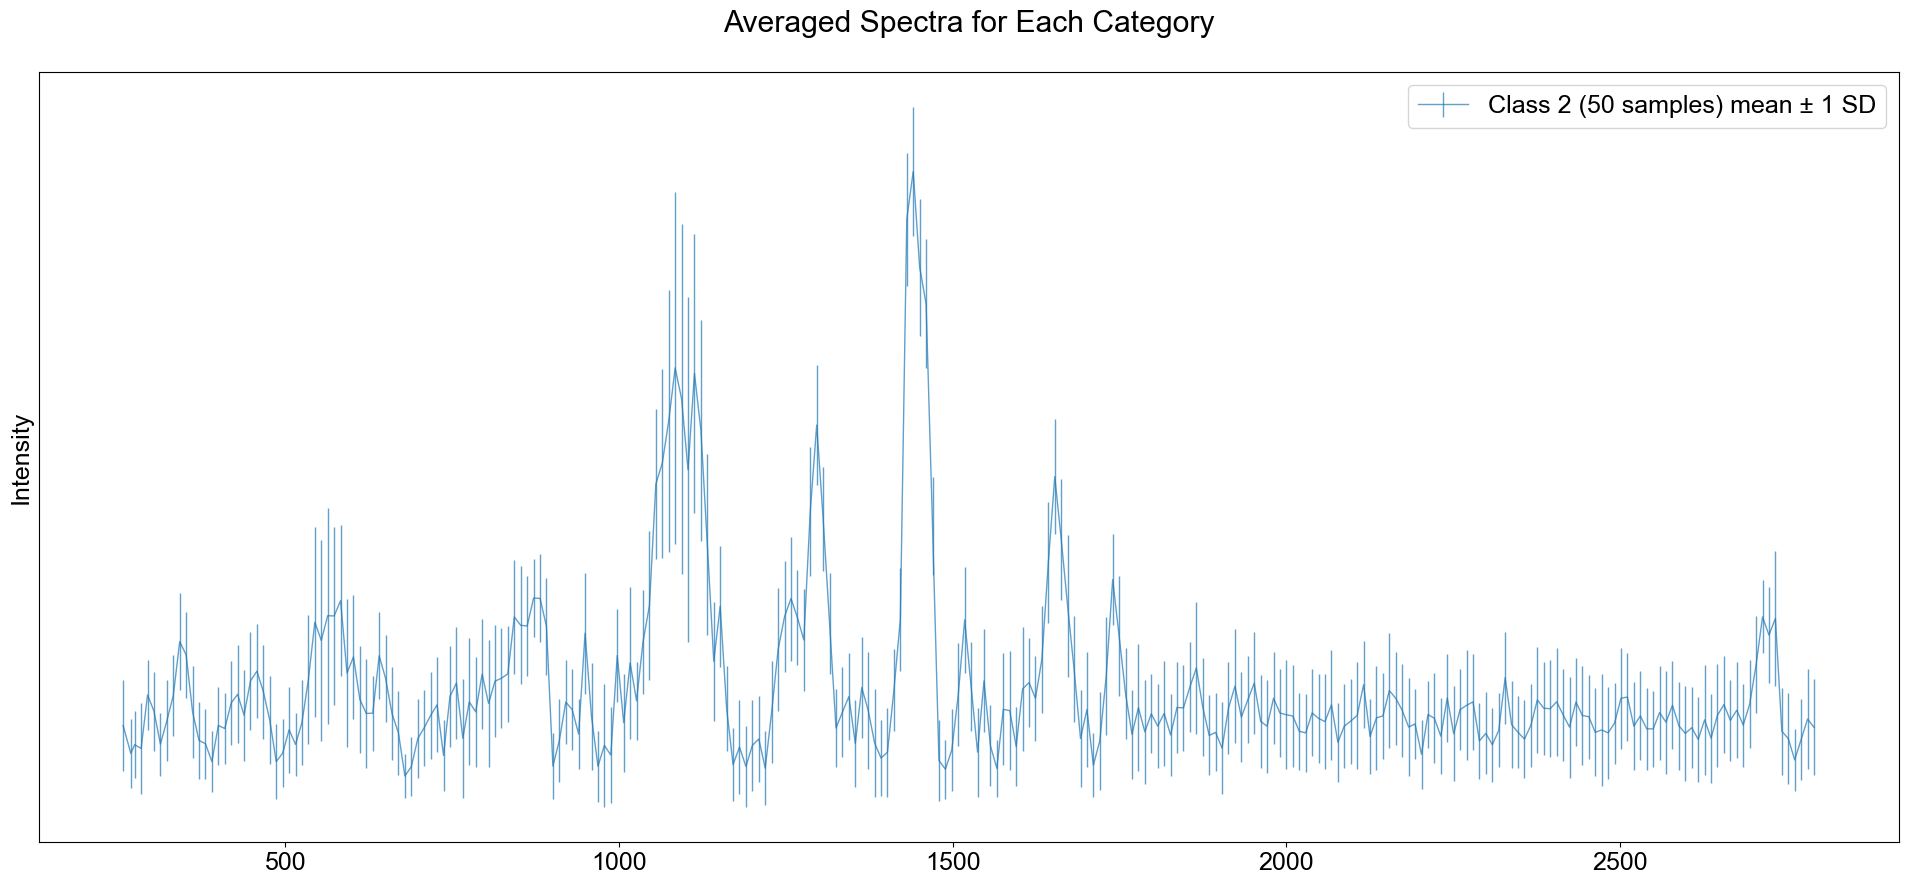

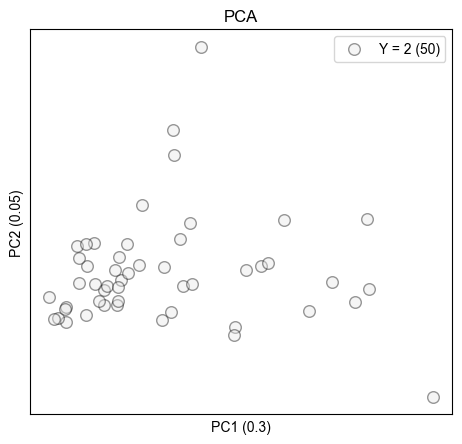

In [29]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-qinhaihu牦牛merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [30]:
X.shape

(50, 264)

In [31]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [35]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [37]:
import numpy as np

# 保存训练集数据
np.savetxt('qinhaihu牦牛.train_data.csv', X_train, delimiter=',')
np.savetxt('qinhaihu牦牛.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('qinhaihu牦牛.test_data.csv', X_test, delimiter=',')
np.savetxt('qinhaihu牦牛.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


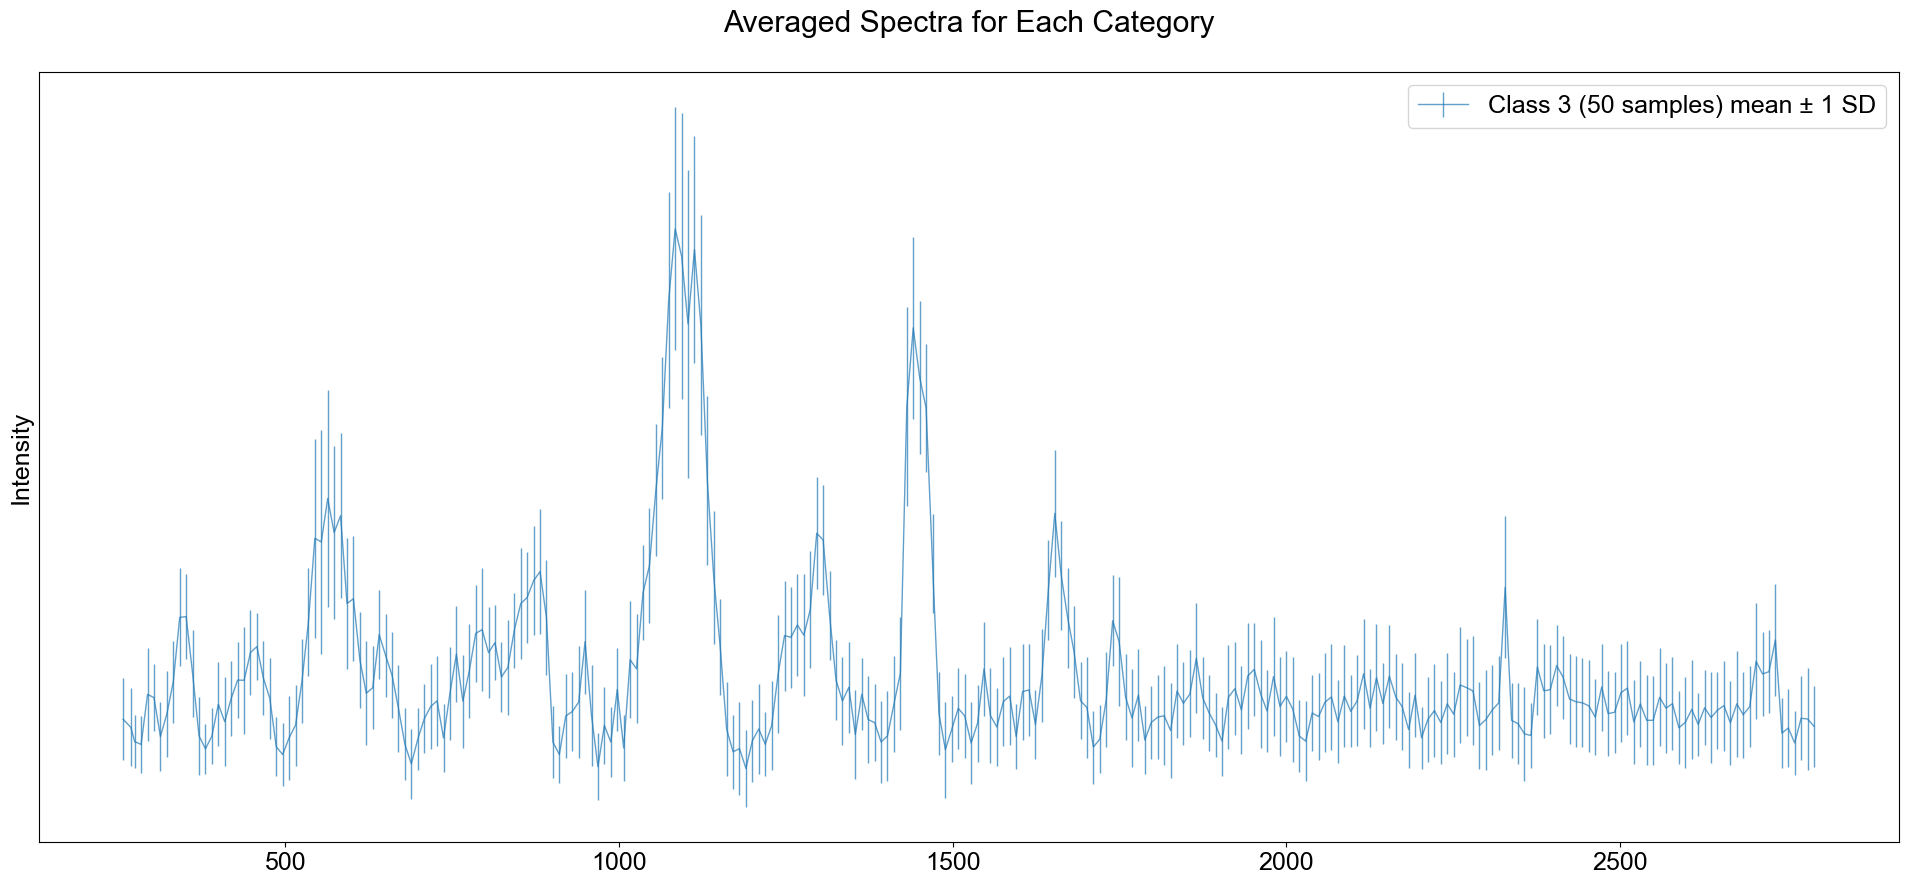

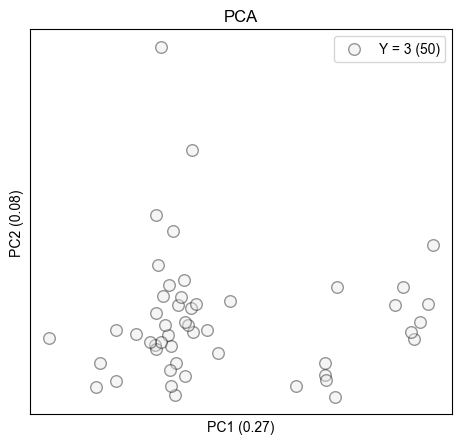

In [39]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-mengyang羊merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [40]:
X.shape

(50, 264)

In [41]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [45]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [47]:
import numpy as np

# 保存训练集数据
np.savetxt('mengyang羊.train_data.csv', X_train, delimiter=',')
np.savetxt('mengyang羊.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('mengyang羊.test_data.csv', X_test, delimiter=',')
np.savetxt('mengyang羊.test_labels.csv', y_test, delimiter=',')

In [11]:
train_files = ['guangming牛.train_data.csv', 'baifeilao水牛.train_data.csv', 'qinhaihu牦牛.train_data.csv', 'mengyang羊.train_data.csv']
test_files = ['guangming牛.test_data.csv', 'baifeilao水牛.test_data.csv', 'qinhaihu牦牛.test_data.csv', 'mengyang羊.test_data.csv']
train_label_files = ['guangming牛.train_labels.csv', 'baifeilao水牛.train_labels.csv', 'qinhaihu牦牛.train_labels.csv', 'mengyang羊.train_labels.csv']
test_label_files = ['guangming牛.test_labels.csv', 'baifeilao水牛.test_labels.csv', 'qinhaihu牦牛.test_labels.csv', 'mengyang羊.test_labels.csv']

In [13]:
X_train = []
X_test = []
y_train = []
y_test = []

for train_file, test_file, train_label_file, test_label_file in zip(train_files, test_files, train_label_files, test_label_files):
    train_data = np.loadtxt(train_file, delimiter=',')
    test_data = np.loadtxt(test_file, delimiter=',')
    train_labels = np.loadtxt(train_label_file, delimiter=',')
    test_labels = np.loadtxt(test_label_file, delimiter=',')

    X_train.append(train_data)
    X_test.append(test_data)
    y_train.append(train_labels)
    y_test.append(test_labels)

X_train = np.concatenate(X_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # 拟合+转换训练集
X_test = scaler.transform(X_test)

In [17]:
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[0.29851428 0.12797299 0.17238775 ... 0.09117443 0.02891403 0.04625851]
 [0.20209034 0.25934671 0.05660193 ... 0.22570283 0.71166506 0.09162628]
 [0.10783901 0.29366751 0.31822572 ... 0.04865937 0.30291556 0.1260964 ]
 ...
 [0.1897004  0.03532538 0.20671201 ... 0.28552144 0.13637482 0.0111826 ]
 [0.23390594 0.02401116 0.12509392 ... 0.32693213 0.2187958  0.20181971]
 [0.         0.14076748 0.46088511 ... 0.044998   0.1298909  0.40887699]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[[0.05718451 0.50476935 0.04459439 ... 0.04681951 0.16035313 0.17333

In [19]:
np.savetxt('merged_train_data.csv', X_train, delimiter=',')
np.savetxt('merged_test_data.csv', X_test, delimiter=',')
np.savetxt('merged_train_labels.csv', y_train, delimiter=',')
np.savetxt('merged_test_labels.csv', y_test, delimiter=',')

In [21]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(y_train)
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


In [23]:
X_train

array([[0.29851428, 0.12797299, 0.17238775, ..., 0.09117443, 0.02891403,
        0.04625851],
       [0.20209034, 0.25934671, 0.05660193, ..., 0.22570283, 0.71166506,
        0.09162628],
       [0.10783901, 0.29366751, 0.31822572, ..., 0.04865937, 0.30291556,
        0.1260964 ],
       ...,
       [0.1897004 , 0.03532538, 0.20671201, ..., 0.28552144, 0.13637482,
        0.0111826 ],
       [0.23390594, 0.02401116, 0.12509392, ..., 0.32693213, 0.2187958 ,
        0.20181971],
       [0.        , 0.14076748, 0.46088511, ..., 0.044998  , 0.1298909 ,
        0.40887699]])

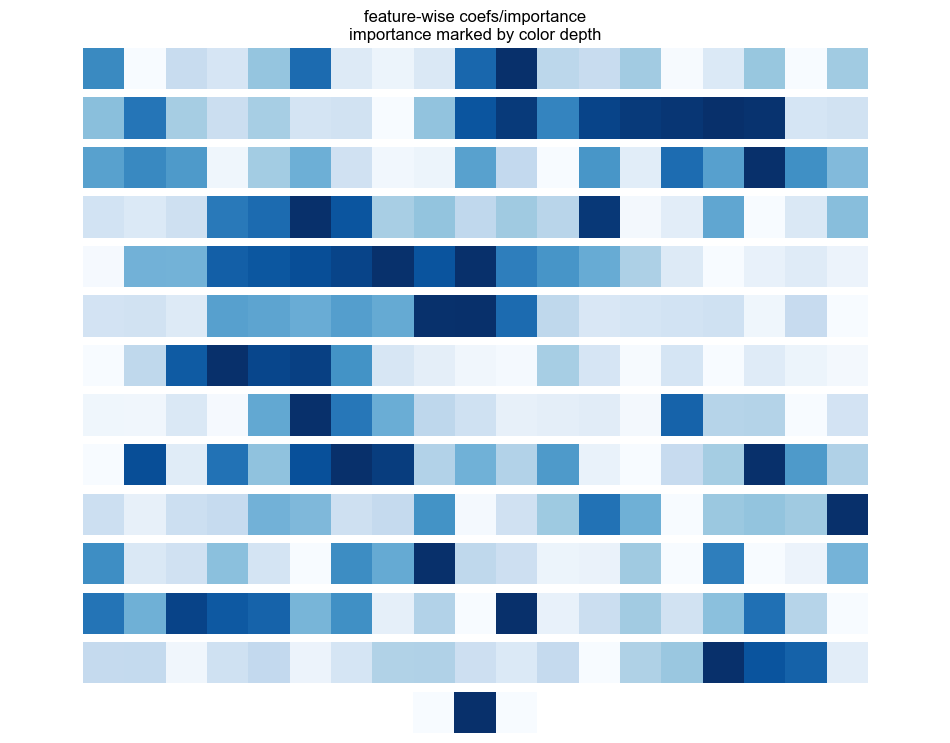

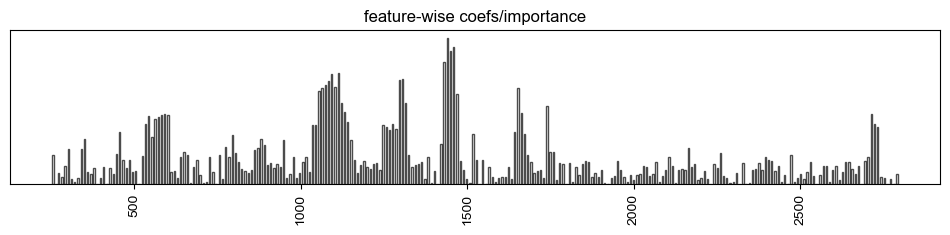

Important feature Number:  9
Important features indices:  [123 125 124 122  89  87 109 108  86]
Important features names:  [1440.754 1460.039 1450.396 1431.112 1112.915 1093.63  1305.761 1296.119
 1083.988]
Top-9 feature Importance:  [1.02370977 0.95907488 0.93334011 0.85320102 0.77443236 0.76936993
 0.73515135 0.73071812 0.71888978]


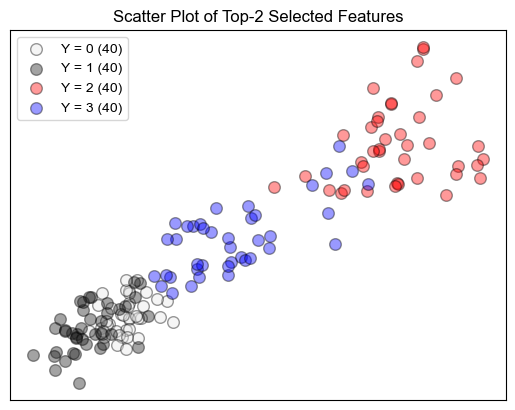

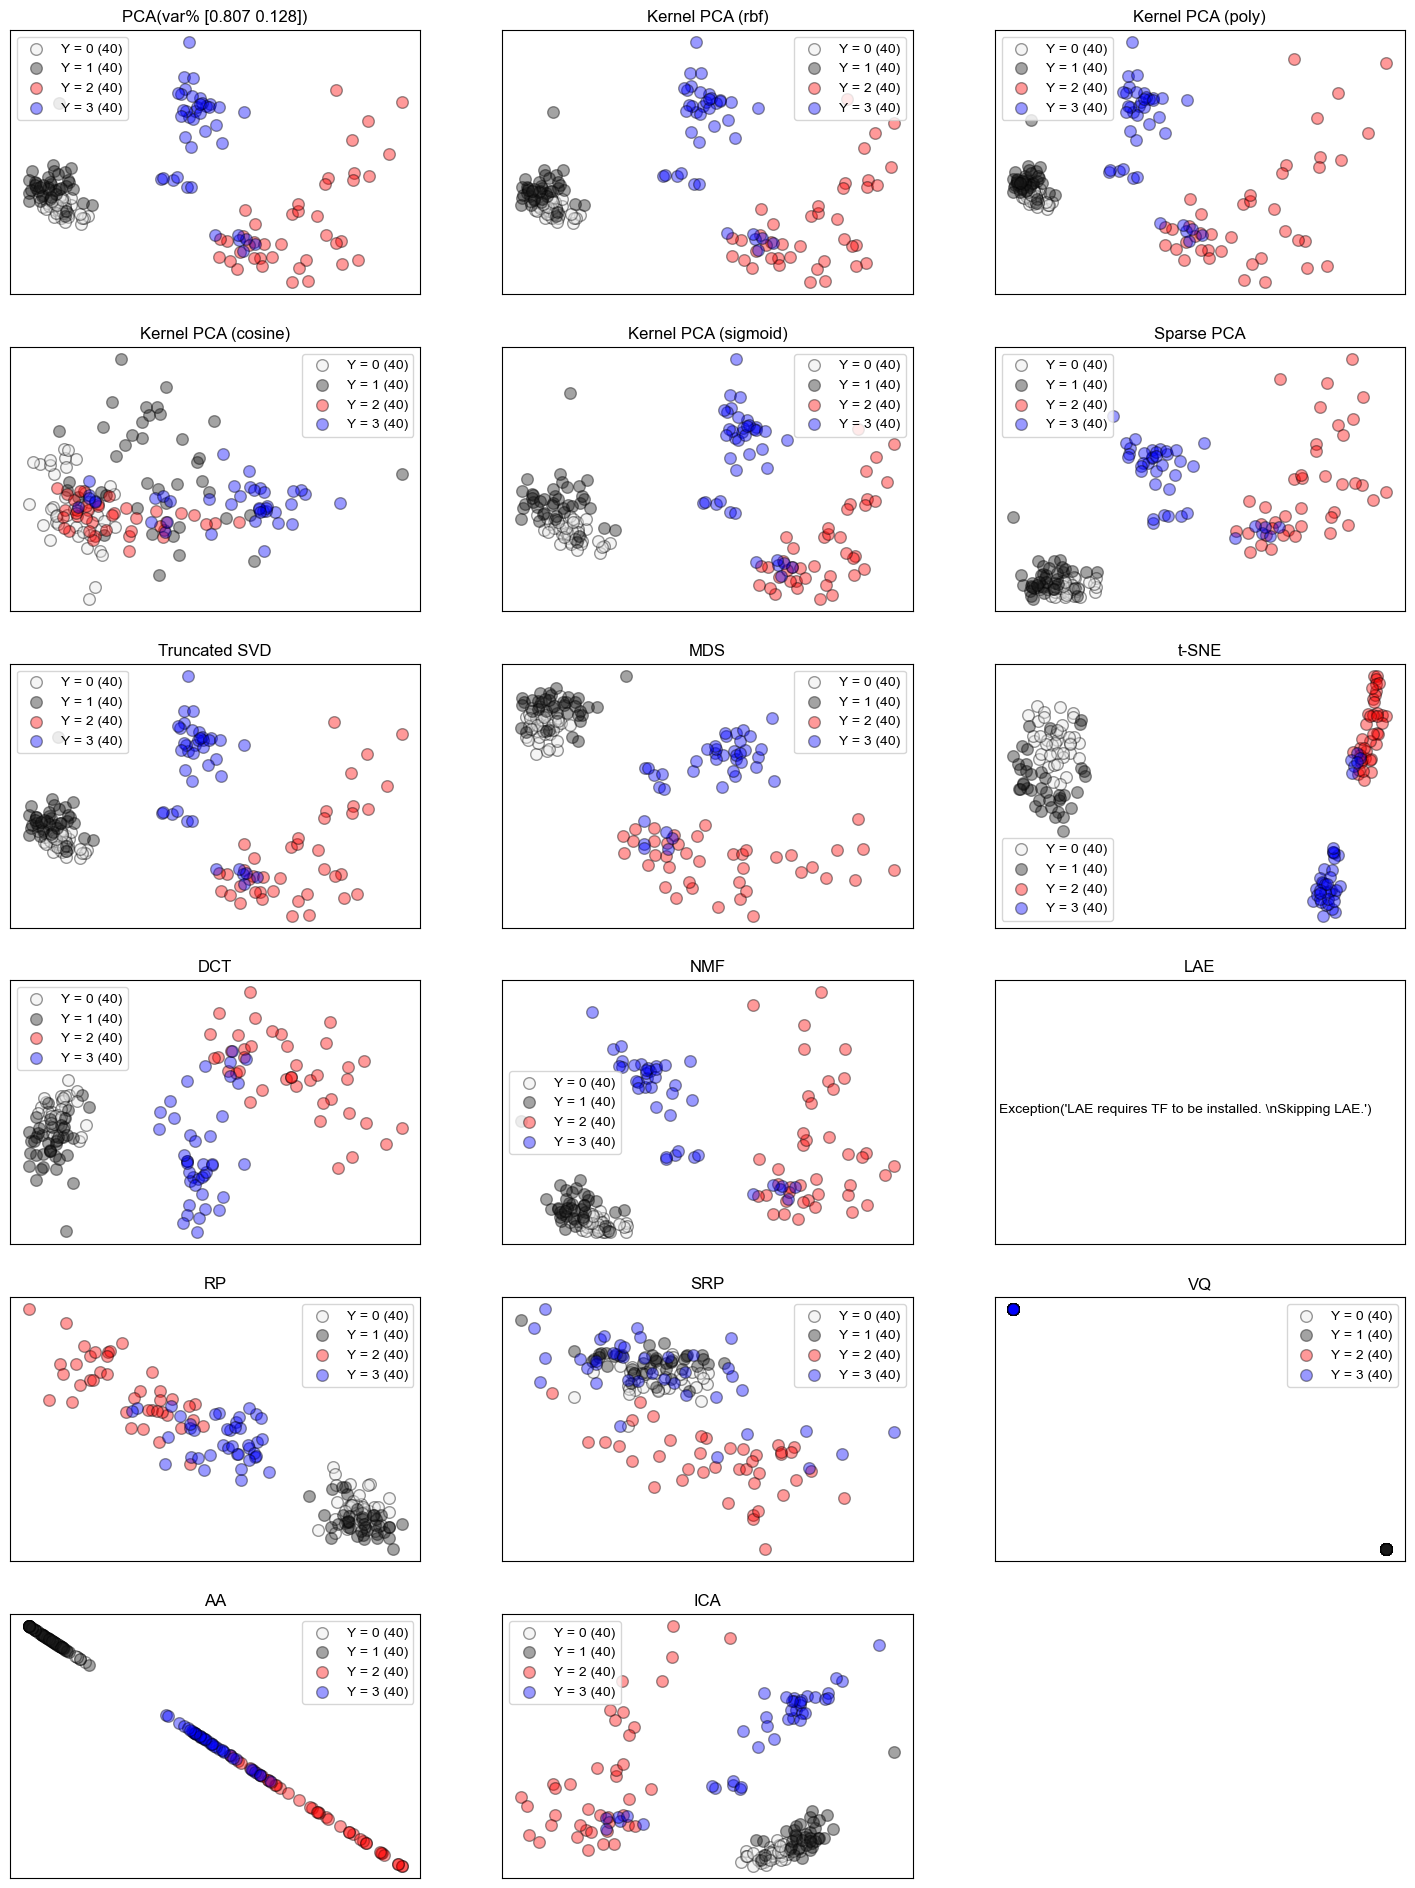

Classification accurary with the selected features (LogisticRegressionCV) =  0.975


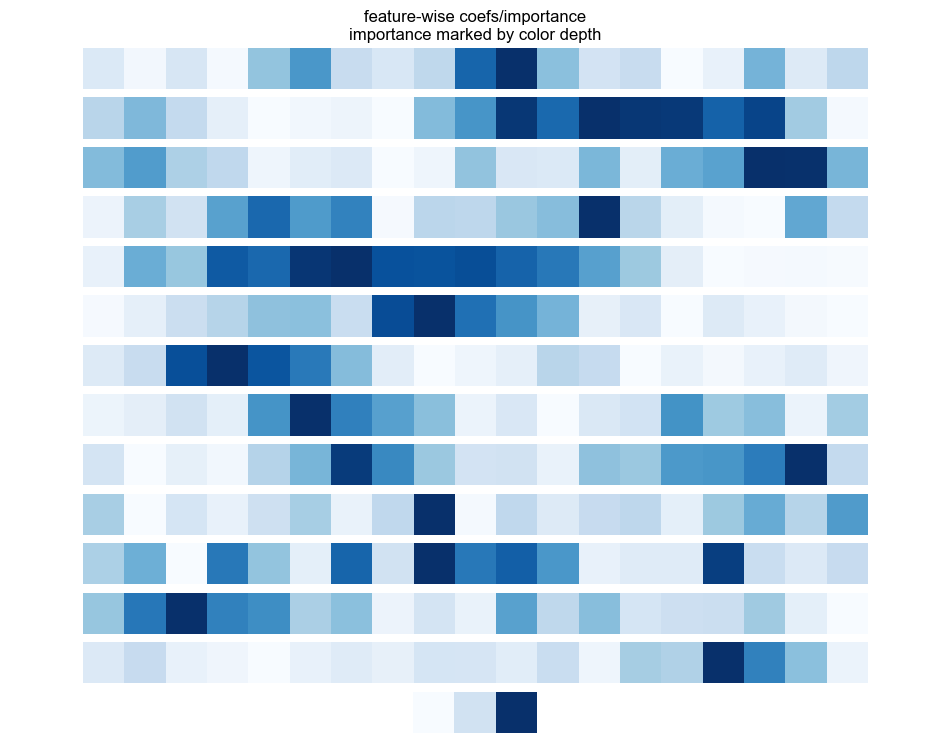

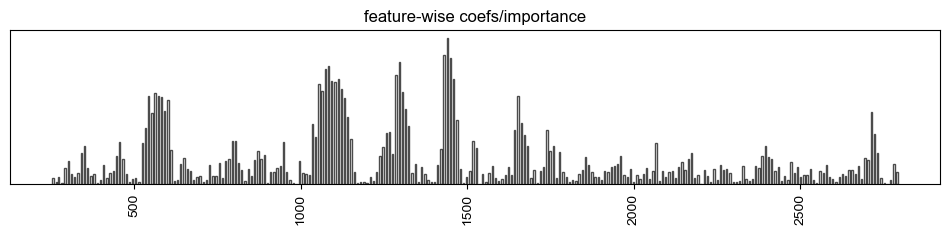

Important feature Number:  9
Important features indices:  [123 122 124 108  86  85 107 125  89]
Important features names:  [1440.754 1431.112 1450.396 1296.119 1083.988 1074.345 1286.477 1460.039
 1112.915]
Top-9 feature Importance:  [28.55534525 25.15445165 24.5268817  23.77470032 23.10383754 22.51080275
 21.19359916 20.4385619  20.42934016]


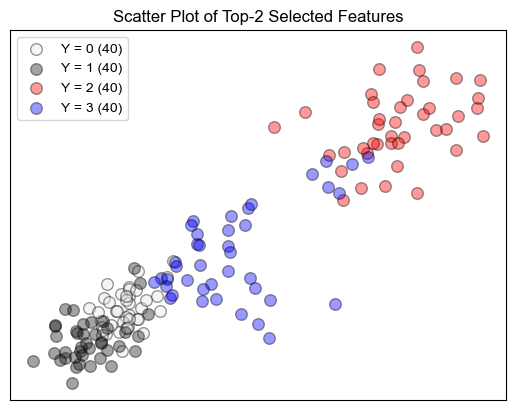

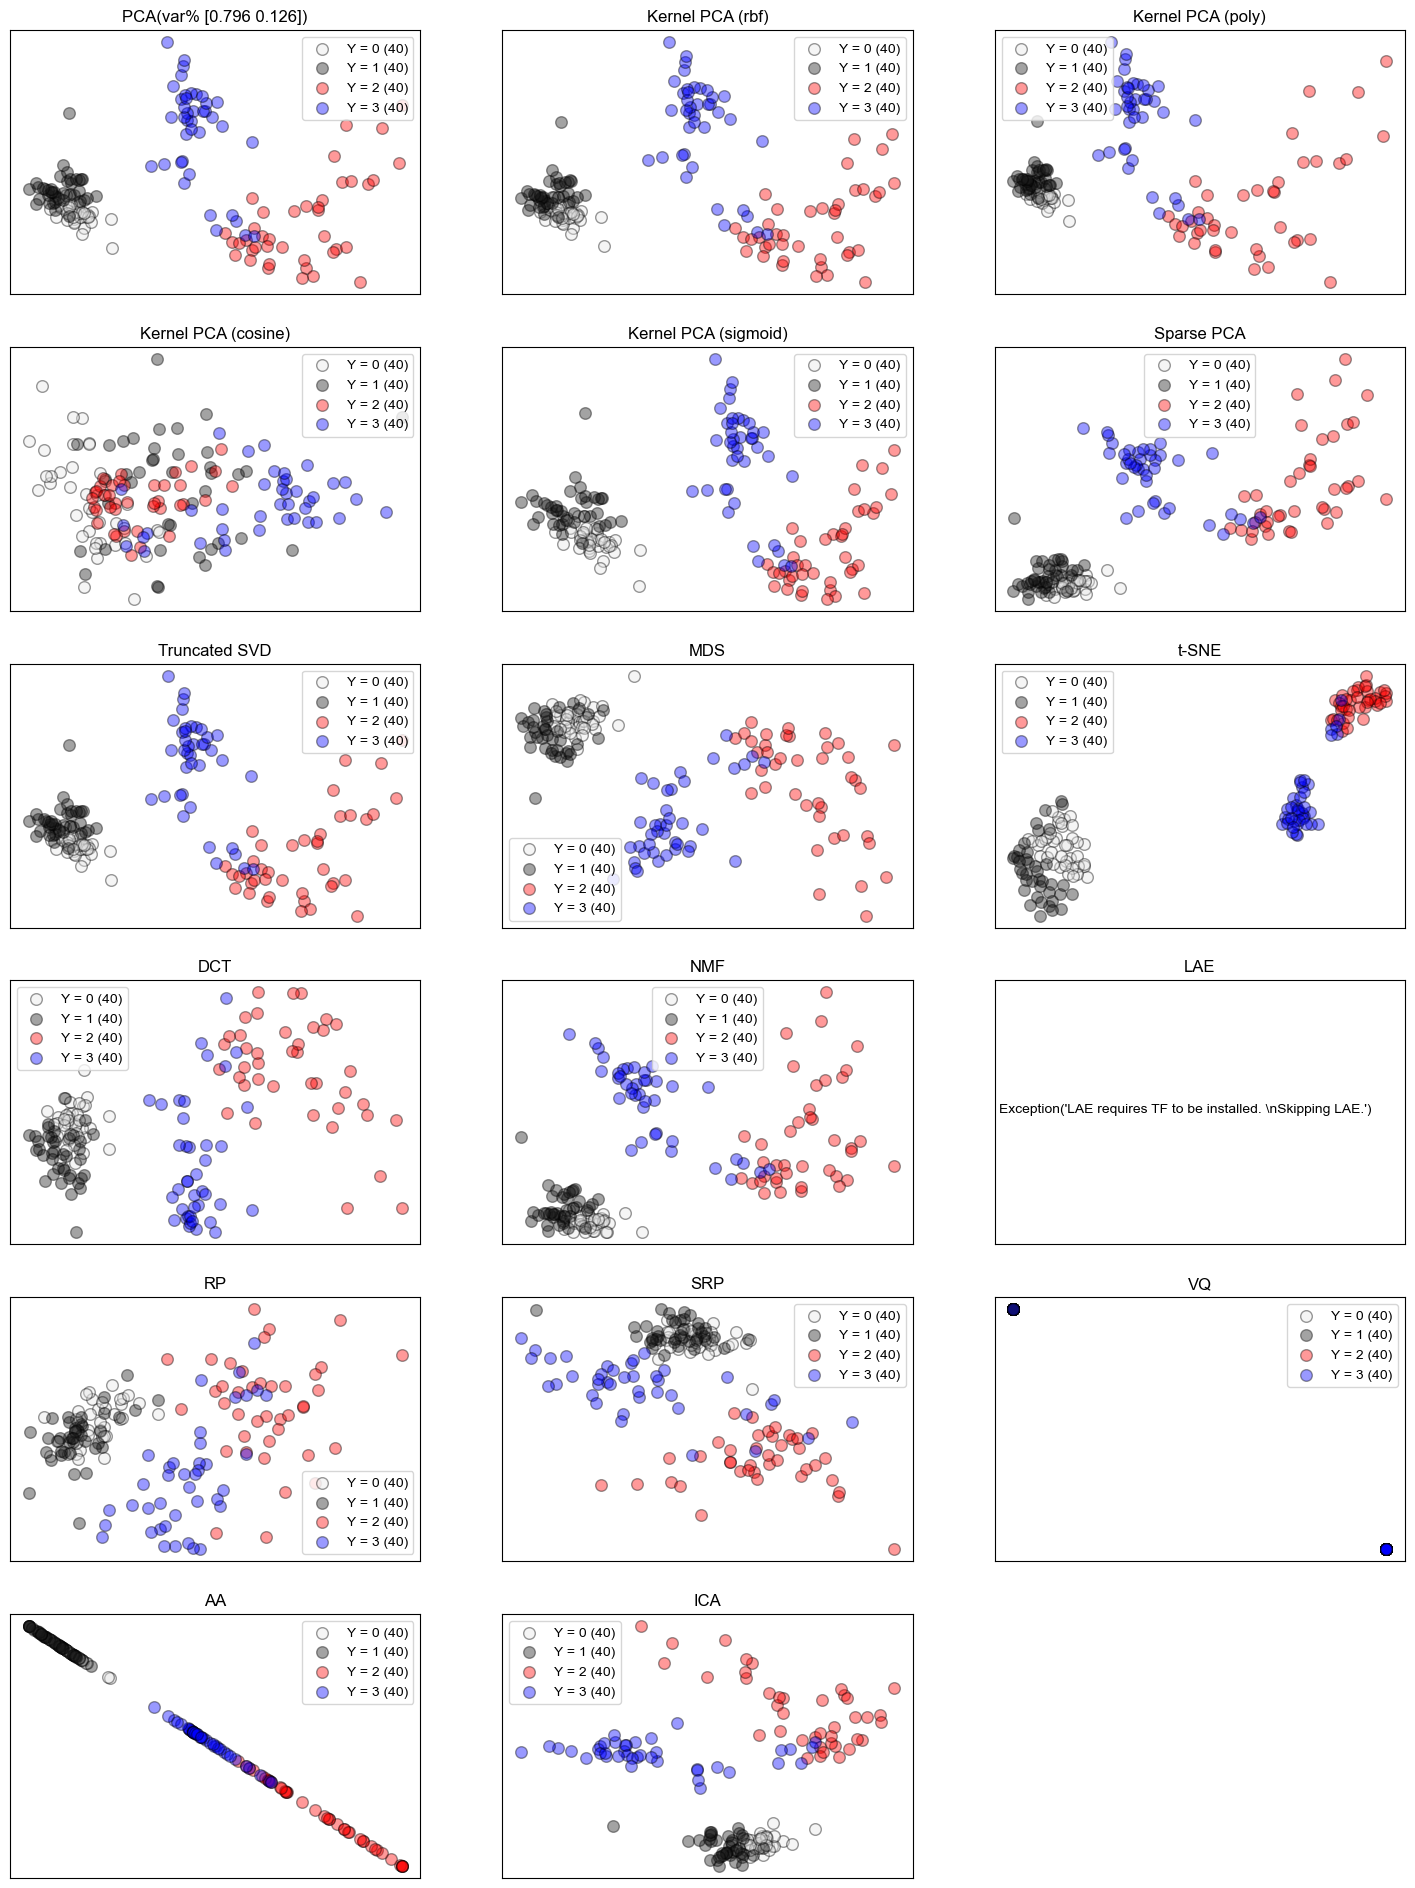

Classification accurary with the selected features (LogisticRegressionCV) =  0.969


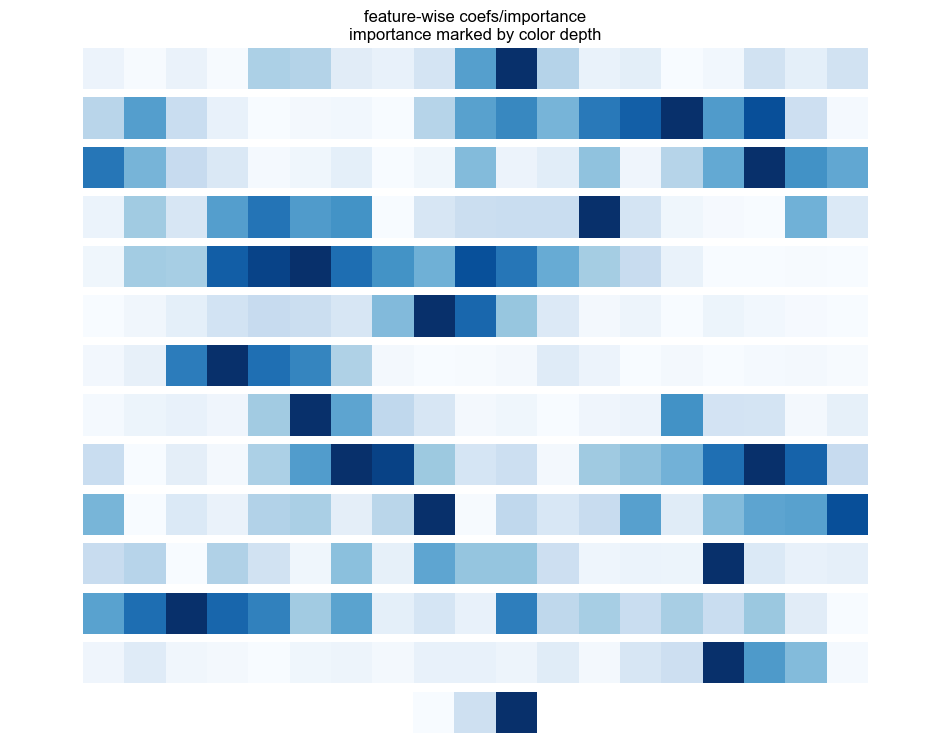

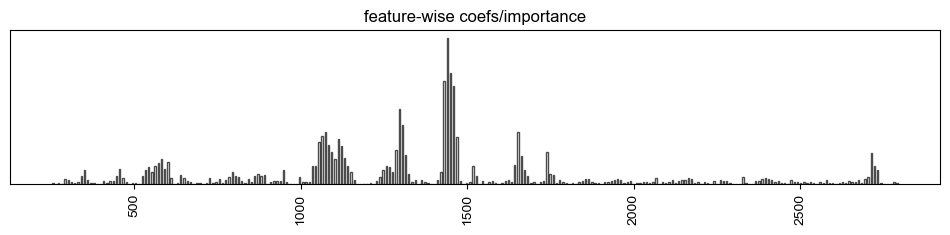

Important feature Number:  9
Important features indices:  [123 124 122 125 108 109 145  85  84]
Important features names:  [1440.754 1450.396 1431.112 1460.039 1296.119 1305.761 1652.885 1074.345
 1064.703]
Top-9 feature Importance:  [457.05684795 346.42091135 321.96321176 306.44765709 235.36049675
 185.07951975 163.06274926 161.61008637 149.24389731]


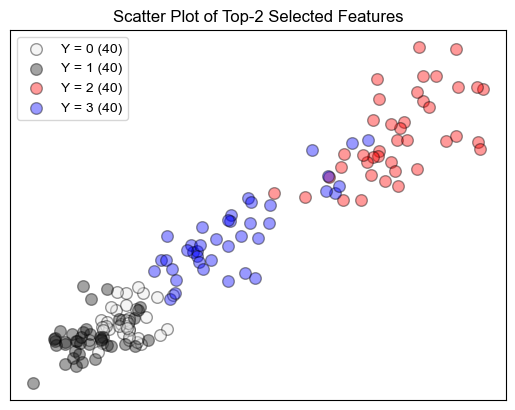

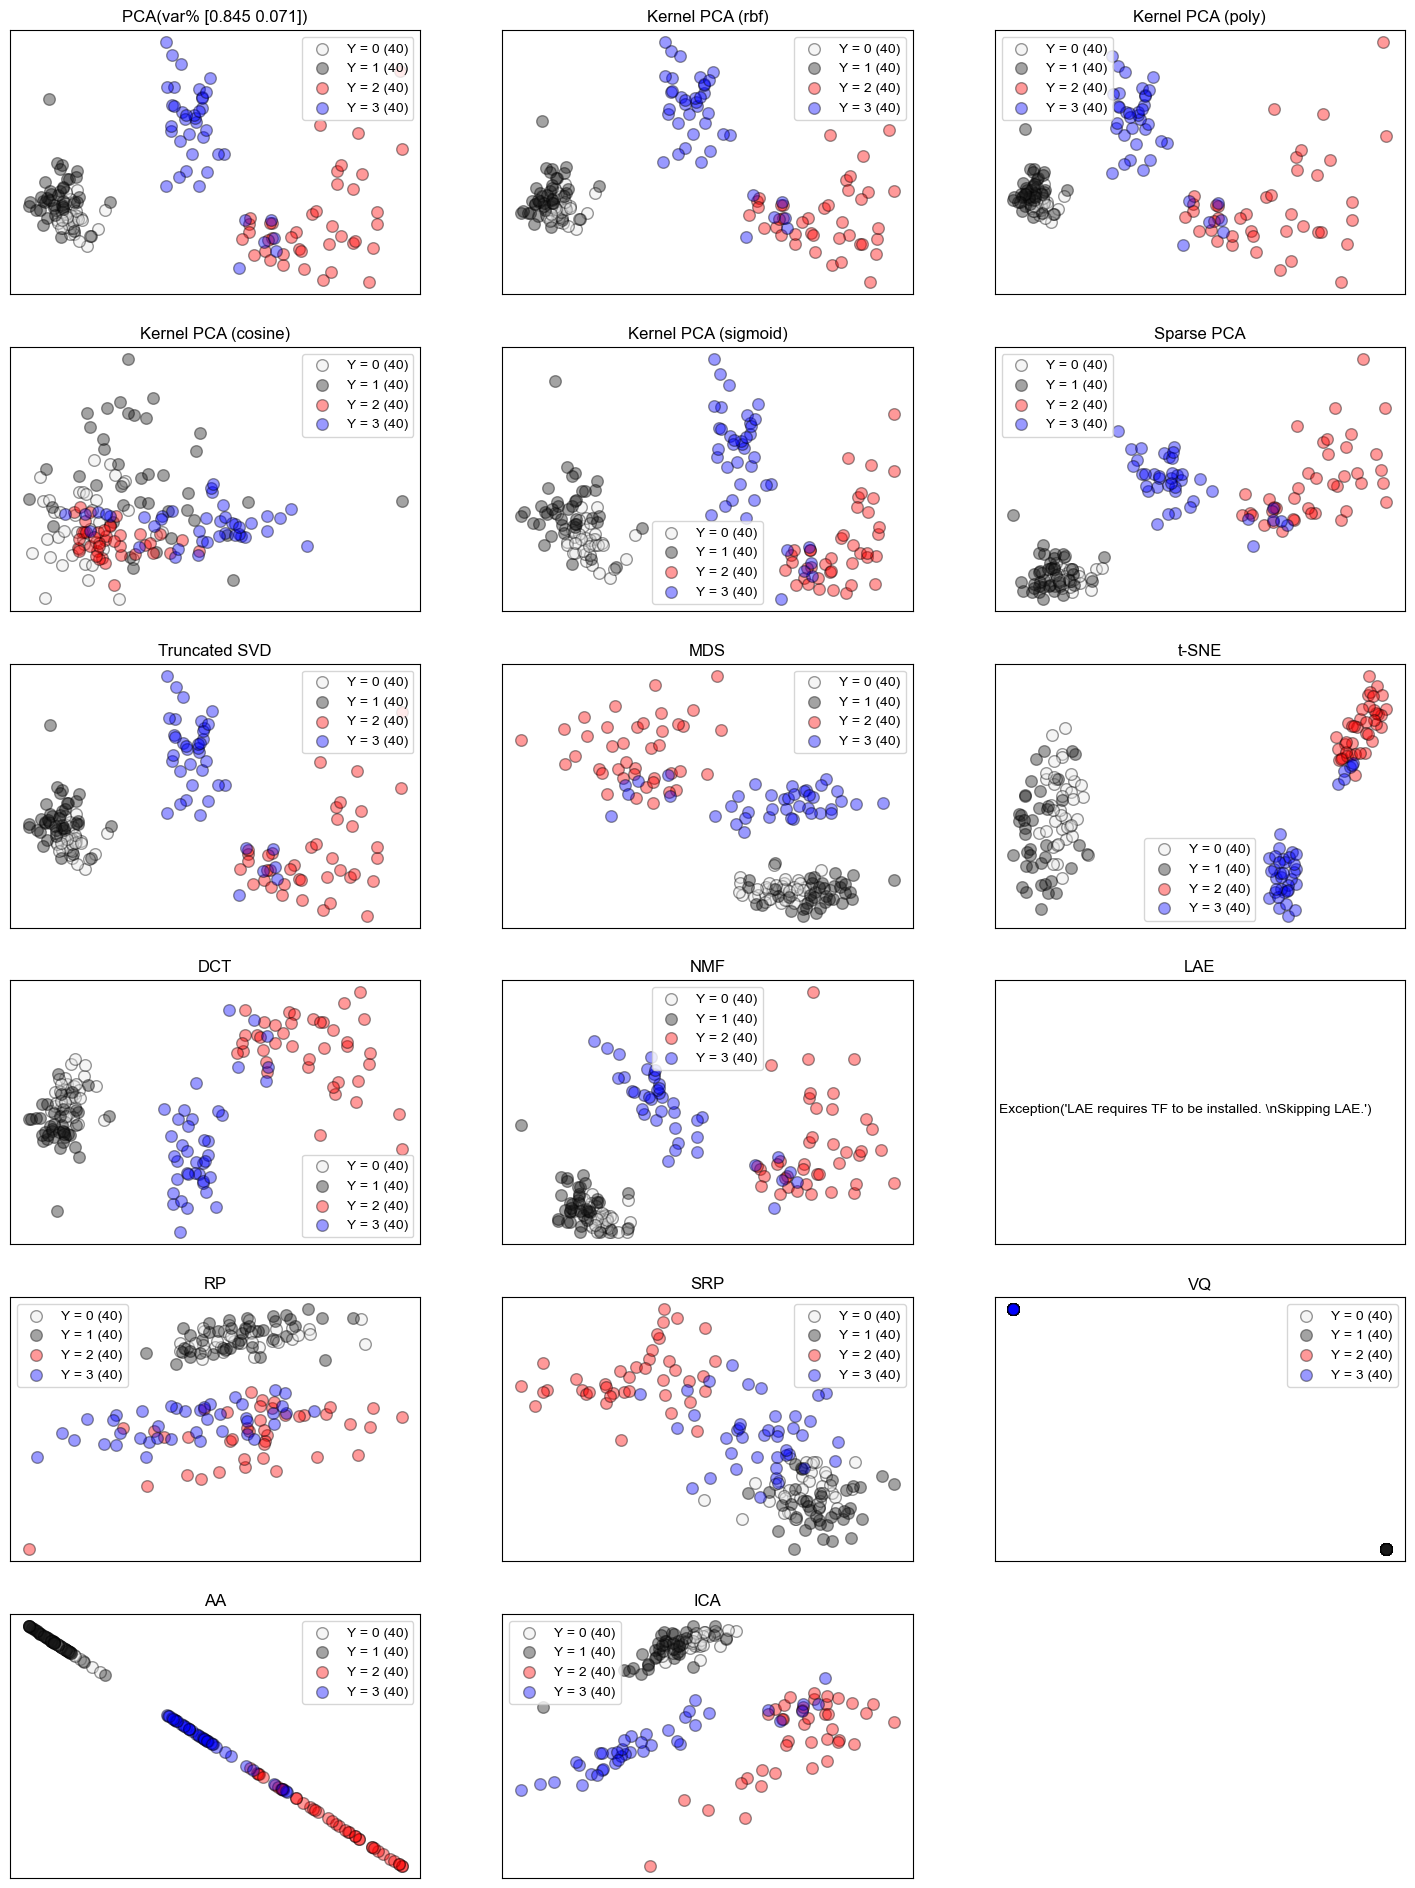

Classification accurary with the selected features (LogisticRegressionCV) =  0.894


In [13]:
from qsi.fs import RUN_ALL_FS
from sklearn.preprocessing import StandardScaler,MinMaxScaler
plt.rcParams['font.family'] = 'Arial'


X_s, _, FS_IDX = RUN_ALL_FS(X_train, y_train, X_names, N = 9, output='all')

In [35]:
#Chi-square
feature_indices = [123,122,124,108,86,87,109,125,89]

In [37]:
Xs_train = X_train[:, feature_indices] # 训练集选择的特征
Xs_train.shape

(160, 9)

In [39]:
# 处理测试集
Xs_test = X_test[:, feature_indices]
Xs_test.shape

(40, 9)

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
def run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test):
    clfs = [
        GaussianNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        LinearSVC(multi_class="crammer_singer"),
        LogisticRegressionCV(multi_class="multinomial", max_iter=1000),
        MLPClassifier(),
        KNeighborsClassifier(),
        LinearDiscriminantAnalysis(),
        ELMClassifier(),
        RVFLClassifier()
    ]

    param_grids = [
        {},
        {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]},
        {'n_estimators': list(range(1, max(10, len(set(y_train)))))},
        {'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000]},
        {},
        {'hidden_layer_sizes': [(x,) for x in range(1, 1000, 10)], 'alpha': [0.0001, 0.01, 1]},
        {'n_neighbors': list(range(1, max(5, len(set(y_train)))))},
        {},
        {'n_hidden_nodes': [1, 2, 5, 10, 20, 25, 30, 35, 40, 50, 60, 75, 100, 150, 200]},
        {'n_hidden_nodes': [1, 2, 5, 10, 20, 40, 50, 60, 70, 80, 90, 100]}
    ]
# 初始化一个列表来存储包含混淆矩阵和分类器名称的字典
    confusion_matrix_results = []
    dic_train_accs = {}
    dic_test_accs = {}

    kfold = KFold(n_splits=3, shuffle=True, random_state=20)

    for i, (clf, param_grid) in enumerate(zip(clfs, param_grids)):
        np.random.seed(20)  # 设置随机种子
        gs = GridSearchCV(clf, param_grid, cv=kfold, n_jobs=1, verbose=0)
        gs.fit(Xs_train, y_train)

        clf = gs.best_estimator_
        clf_name = str(clf)
        
        dic_train_accs[clf_name] = [clf.score(Xs_train, y_train)]
        y_pred_train = clf.predict(Xs_train)
        train_cm = confusion_matrix(y_train, y_pred_train)
        print(f"{clf_name} Training Set Confusion Matrix:")
        print(train_cm)
        if len(set(y_train)) >= 8:
            y_score_train = clf.predict_proba(Xs_train)
            y_score_train = np.nan_to_num(y_score_train)
            dic_train_accs[clf_name].append(top_k_accuracy_score(y_train, y_score_train, k=3))
            dic_train_accs[clf_name].append(top_k_accuracy_score(y_train, y_score_train, k=5))

        dic_test_accs[clf_name] = [clf.score(Xs_test, y_test)]
        y_pred_test = clf.predict(Xs_test)
        test_cm = confusion_matrix(y_test, y_pred_test)
        print(f"{clf_name} Test Set Confusion Matrix:")
        print(test_cm)
        if len(set(y_train)) >= 8:
            y_score_test = clf.predict_proba(Xs_test)
            y_score_test = np.nan_to_num(y_score_test)
            dic_test_accs[clf_name].append(top_k_accuracy_score(y_test, y_score_test, k=3))
            dic_test_accs[clf_name].append(top_k_accuracy_score(y_test, y_score_test, k=5))
                        
        # 创建一个包含混淆矩阵和分类器名称的字典
        confusion_matrix_dict = {
            'classifier_name': str(clf),
            'train_cm': train_cm,
            'test_cm': test_cm
        }

        # 将字典添加到列表中
        confusion_matrix_results.append(confusion_matrix_dict)

        print(clf_name)
        print("Training set:")
        print("Top-1 accuracy:", format(dic_train_accs[clf_name][0], '.5f'))
        if len(set(y_train)) >= 8:
            print("Top-3 accuracy:", format(dic_train_accs[clf_name][1], '.5f'))
            print("Top-5 accuracy:", format(dic_train_accs[clf_name][2], '.5f'))

        print("Test set:")
        print("Top-1 accuracy:", format(dic_test_accs[clf_name][0], '.5f'))
        if len(set(y_train)) >= 8:
            print("Top-3 accuracy:", format(dic_test_accs[clf_name][1], '.5f'))
            print("Top-5 accuracy:", format(dic_test_accs[clf_name][2], '.5f'))   
        print("")

        # Plot confusion matrix and normalized confusion matrix for train set
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # 修改点2：替换原 plot_confusion_matrix 绘制训练集未归一化混淆矩阵
        train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=clf.classes_)
        train_disp.plot(ax=ax[0], cmap='Blues')
        ax[0].set_title('Train Set - Confusion Matrix')

        # 修改点3：替换原 plot_confusion_matrix 绘制训练集归一化混淆矩阵
        train_disp_normalized = ConfusionMatrixDisplay(confusion_matrix=train_cm / train_cm.sum(axis=1)[:, np.newaxis],
                                                       display_labels=clf.classes_)
        train_disp_normalized.plot(ax=ax[1], cmap='Blues')
        ax[1].set_title('Train Set - Normalized Confusion Matrix')
        plt.show()

        # Plot confusion matrix and normalized confusion matrix for test set
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # 修改点4：替换原 plot_confusion_matrix 绘制测试集未归一化混淆矩阵
        test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=clf.classes_)
        test_disp.plot(ax=ax[0], cmap='Blues')
        ax[0].set_title('Test Set - Confusion Matrix')

        # 修改点5：替换原 plot_confusion_matrix 绘制测试集归一化混淆矩阵
        test_disp_normalized = ConfusionMatrixDisplay(confusion_matrix=test_cm / test_cm.sum(axis=1)[:, np.newaxis],
                                                      display_labels=clf.classes_)
        test_disp_normalized.plot(ax=ax[1], cmap='Blues')
        ax[1].set_title('Test Set - Normalized Confusion Matrix')
        plt.show()

        
        
        
        # 遍历列表，处理每个模型的混淆矩阵
    for result in confusion_matrix_results:
        classifier_name = result['classifier_name']
        train_cm = result['train_cm']
        test_cm = result['test_cm']

        # 初始化类别指标列表
        category_train_precisions = []
        category_train_recalls = []
        category_train_f1_scores = []
        category_train_accuracies = []
        category_test_precisions = []
        category_test_recalls = []
        category_test_f1_scores = []
        category_test_accuracies = []
         # 计算训练集和测试集的每个类别的指标
        for i in range(4):
            train_TP = train_cm[i][i]
            train_FP = sum([j[i] for j in train_cm]) - train_TP
            train_FN = sum(train_cm[i]) - train_TP

            test_TP = test_cm[i][i]
            test_FP = sum([j[i] for j in test_cm]) - test_TP
            test_FN = sum(test_cm[i]) - test_TP

            train_precision = train_TP / (train_TP + train_FP) if (train_TP + train_FP) > 0 else 0
            train_recall = train_TP / (train_TP + train_FN) if (train_TP + train_FN) > 0 else 0
            train_f1 = (2 * train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) > 0 else 0
            train_accuracy = train_TP / sum(train_cm[i]) if sum(train_cm[i]) > 0 else 0

            test_precision = test_TP / (test_TP + test_FP) if (test_TP + test_FP) > 0 else 0
            test_recall = test_TP / (test_TP + test_FN) if (test_TP + test_FN) > 0 else 0
            test_f1 = (2 * test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0
            test_accuracy = test_TP / sum(test_cm[i]) if sum(test_cm[i]) > 0 else 0


            # 将结果添加到相应的列表中
            category_train_precisions.append(train_precision)
            category_train_recalls.append(train_recall)
            category_train_f1_scores.append(train_f1)
            category_train_accuracies.append(train_accuracy)
            category_test_precisions.append(test_precision)
            category_test_recalls.append(test_recall)
            category_test_f1_scores.append(test_f1)
            category_test_accuracies.append(test_accuracy)

        # 计算并打印模型的总体平均指标
        print(f"{classifier_name} 训练集总体平均准确率（Accuracy）: {sum(category_train_accuracies) / 4:.5f}")
        print(f"{classifier_name} 训练集总体平均精确率（Precision）: {sum(category_train_precisions) / 4:.5f}")
        print(f"{classifier_name} 训练集总体平均召回率（Recall）: {sum(category_train_recalls) / 4:.5f}")
        print(f"{classifier_name} 训练集总体平均F1分数（F1 Score）: {sum(category_train_f1_scores) / 4:.5f}\n")

        print(f"{classifier_name} 测试集总体平均准确率（Accuracy）: {sum(category_test_accuracies) / 4:.5f}")
        print(f"{classifier_name} 测试集总体平均精确率（Precision）: {sum(category_test_precisions) / 4:.5f}")
        print(f"{classifier_name} 测试集总体平均召回率（Recall）: {sum(category_test_recalls) / 4:.5f}")
        print(f"{classifier_name} 测试集总体平均F1分数（F1 Score）: {sum(category_test_f1_scores) / 4:.5f}\n")
        
        
        
        
    return dic_train_accs, dic_test_accs

GaussianNB() Training Set Confusion Matrix:
[[40  0  0  0]
 [ 3 37  0  0]
 [ 0  0 40  0]
 [ 0  0  5 35]]
GaussianNB() Test Set Confusion Matrix:
[[ 9  1  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  1  9]]
GaussianNB()
Training set:
Top-1 accuracy: 0.95000
Test set:
Top-1 accuracy: 0.95000



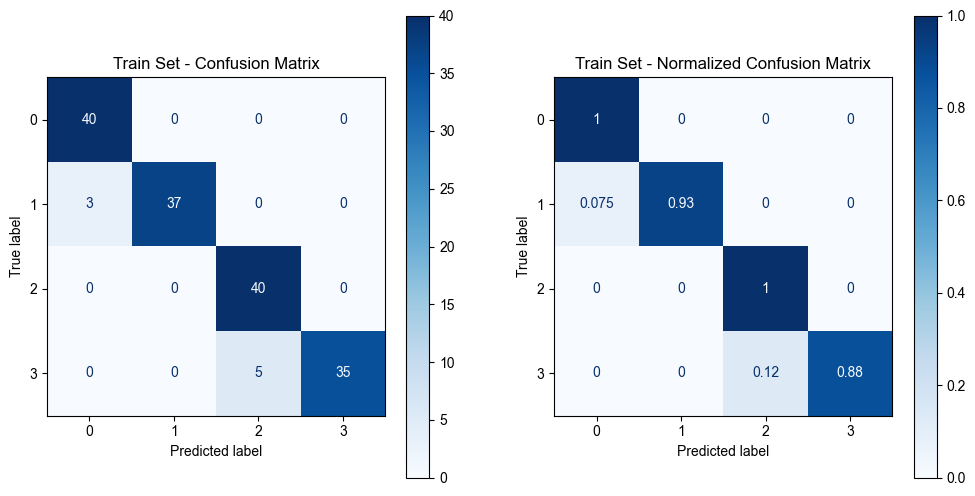

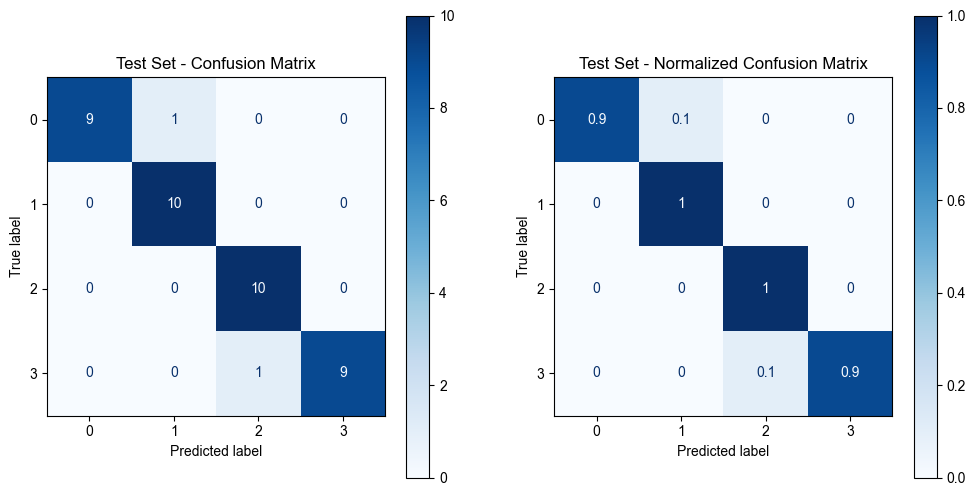

DecisionTreeClassifier(max_depth=10) Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]]
DecisionTreeClassifier(max_depth=10) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
DecisionTreeClassifier(max_depth=10)
Training set:
Top-1 accuracy: 1.00000
Test set:
Top-1 accuracy: 1.00000



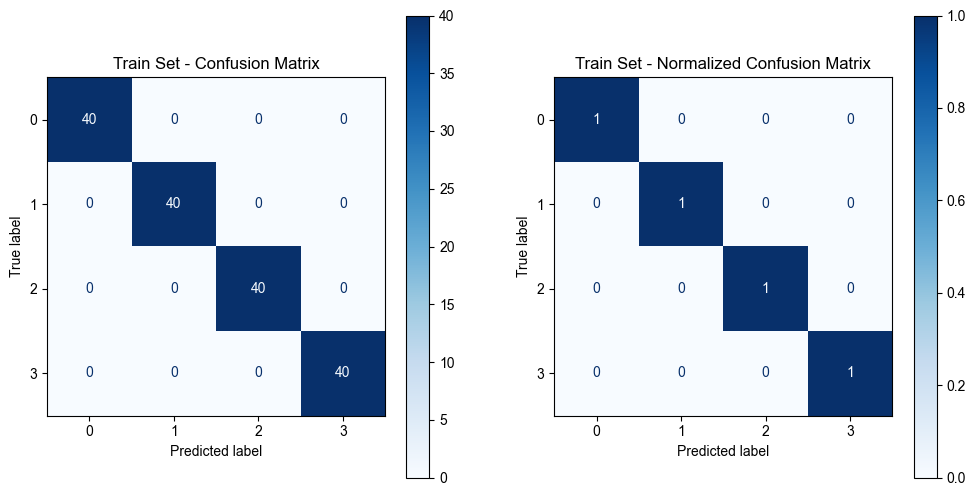

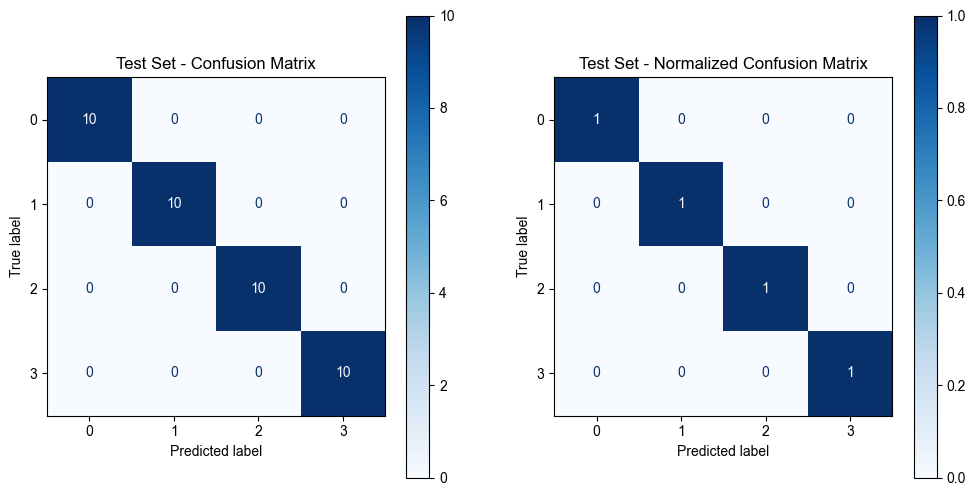

RandomForestClassifier(n_estimators=5) Training Set Confusion Matrix:
[[39  1  0  0]
 [ 1 39  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]]
RandomForestClassifier(n_estimators=5) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
RandomForestClassifier(n_estimators=5)
Training set:
Top-1 accuracy: 0.98750
Test set:
Top-1 accuracy: 1.00000



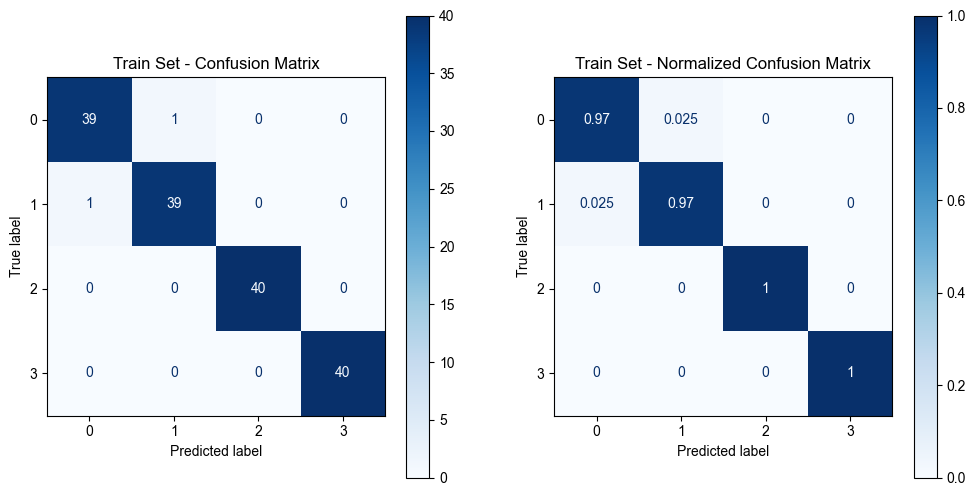

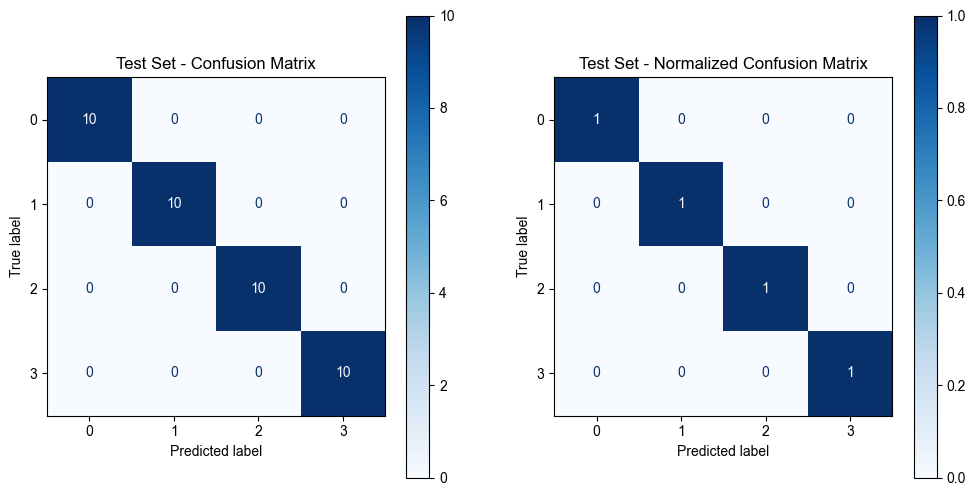

LinearSVC(C=10, multi_class='crammer_singer') Training Set Confusion Matrix:
[[40  0  0  0]
 [ 5 35  0  0]
 [ 0  0 40  0]
 [ 0  0  3 37]]
LinearSVC(C=10, multi_class='crammer_singer') Test Set Confusion Matrix:
[[ 9  1  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
LinearSVC(C=10, multi_class='crammer_singer')
Training set:
Top-1 accuracy: 0.95000
Test set:
Top-1 accuracy: 0.97500



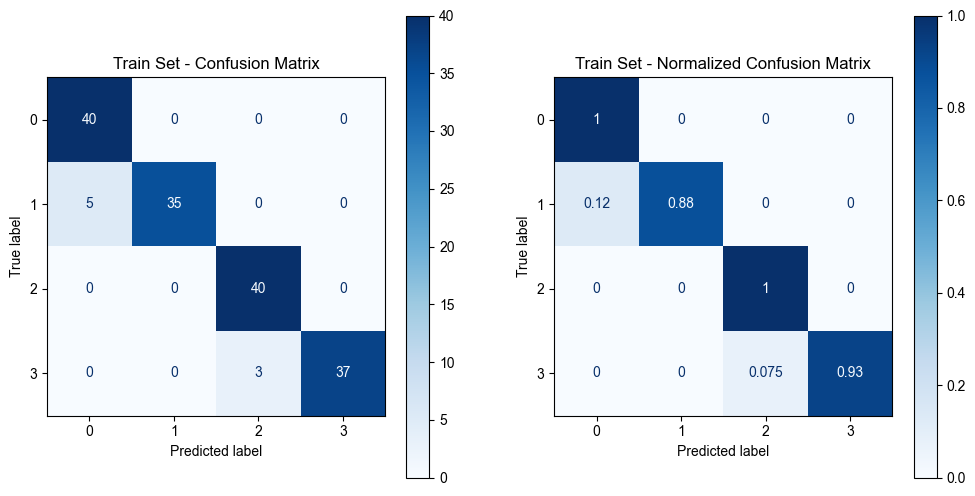

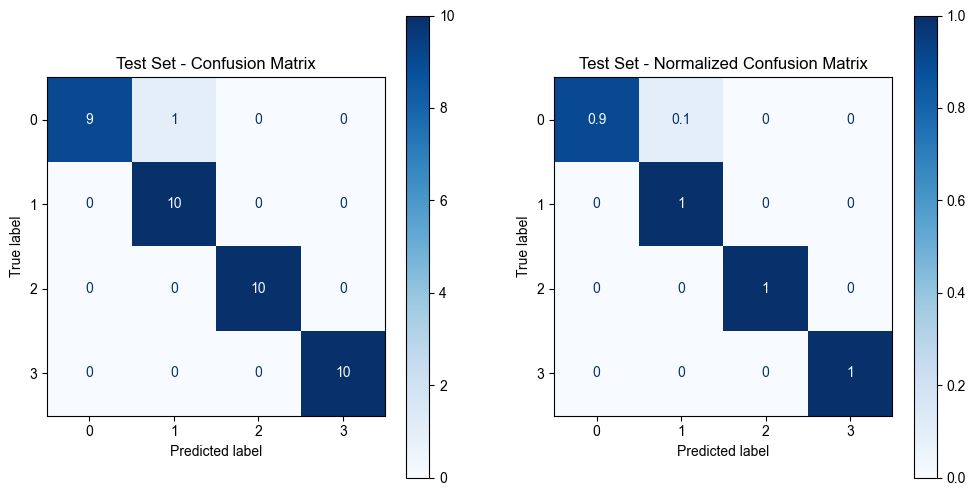

LogisticRegressionCV(max_iter=1000, multi_class='multinomial') Training Set Confusion Matrix:
[[39  1  0  0]
 [ 3 37  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]]
LogisticRegressionCV(max_iter=1000, multi_class='multinomial') Test Set Confusion Matrix:
[[ 9  1  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
LogisticRegressionCV(max_iter=1000, multi_class='multinomial')
Training set:
Top-1 accuracy: 0.97500
Test set:
Top-1 accuracy: 0.97500



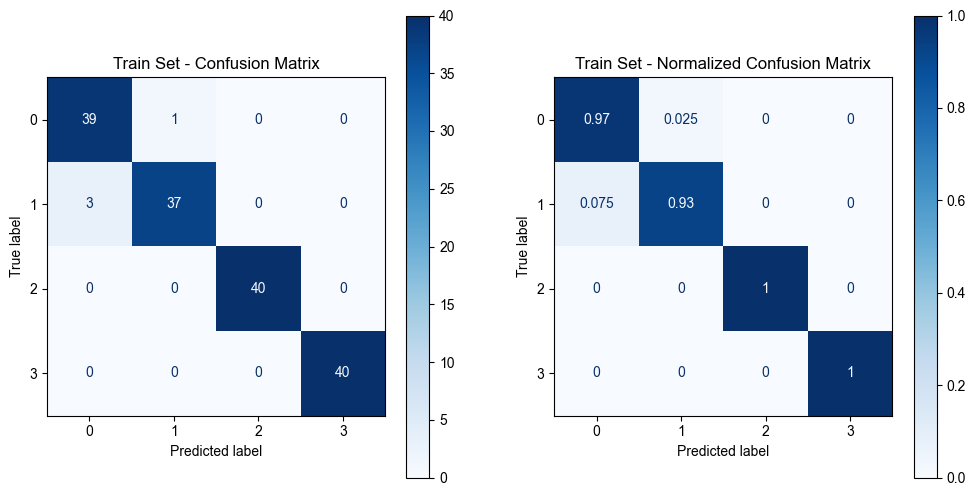

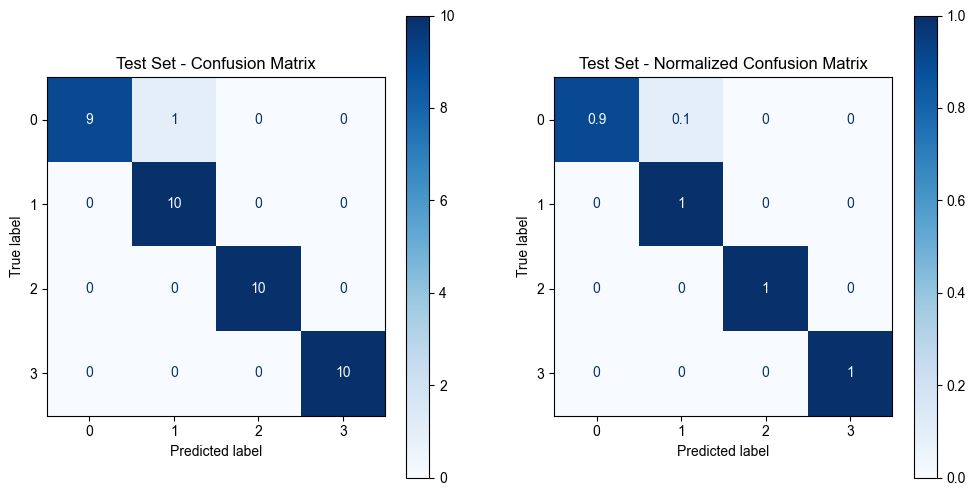

In [ ]:
dic_train_accs, dic_test_accs = run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test)